# L'algorithme LinUCB en action : Test de l'algorithme sur un cas fictif et étude de ses résultats
Etienne Kintzler

In [26]:
import numpy as np
from numpy.linalg import inv
from numpy import matmul as mult
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [11]:
%matplotlib inline

### I) Création de la matrice des features et des vrais paramètres du problème (design matrix)

#### Définition du nombre de features, du nombre de bras/clients, du nombre de périodes

In [55]:
n_arms     = 40
n_features = 11
T          = 500

In [56]:
X  = [None] * n_arms
mu = np.arange(n_arms)

On remplit la matrice des features avec des tirages aléatoires (ça sera nos leads).

In [57]:
for i in np.arange(n_arms):
    X[i] = np.random.rand(n_features * T).reshape(T, n_features)

#### Définition de la vrai valeur des paramètre.
ATTENTION : cette valeur est bien évidemment inconnue dans les cas réels, c'est ce qu'on cherche à approximer. Ici on vérifie avec des valeurs qu'on connait que l'algorithme retrouve bien la bonne valeur des paramètres

In [78]:
real_theta = np.repeat(0.0, n_features * n_arms).reshape(n_arms, n_features)

In [79]:
for p in range(n_features):
    real_theta[:, p] = np.random.rand(n_arms)

#### Création de "super" clients à la rentabilité supérieur
On fixe les valeurs des paramètres de tel sorte qu'ils soient les plus rentables dans notre cas.
Si tout se passe bien, l'algorithme devrait exploiter principalement ces meilleurs bras

best_arm = 12, 17
real_theta[best_arm, :] = np.random.normal(loc = 10,  size=n_features), np.random.normal(loc= 14, size = n_features)

### II) Algorithme LinUCB with disjoin linear models
(Algorithme 1, p664, A Contextual-Bandit Approach to Personalized News Article Recommendation, Li et al.)

#### Paramètre principal de l'algorithme.
Une valeur élevé de alpha = stratégie d'exploration plus importante.

Une valeur faible de alpha = stratégie d'exploitation plus importante.

NB : exploration = on teste des bras différents, exploitation = on reste sur le bras qui nous "parait" rentable.

In [95]:
alpha = .1

#### Création des objets où l'on va stocker les différentes valeurs de l'algo

#### Procédures de l'algorithme

In [96]:
def algo_linUCB(X):
    
    n_arms = len(X)
    n_features = X[1].shape[1]
    T = X[1].shape[0]
    
    A, b   = [None] * n_arms, [None] * n_arms
    theta  = np.repeat(0.0, n_features * n_arms).reshape(n_arms, n_features)
    p      = np.repeat(0.0, n_arms * T).reshape(T, n_arms)
    best_a = [0] * T
    r      = [0.0] * T
    mean_theta =  np.repeat(0.0, n_features * T).reshape(T, n_features)

    

    for i in range(n_arms):    
        A[i] = np.identity(n_features)
        b[i] = np.repeat(0.0, n_features)
        

    for t in range(T):
    
        for i in range(n_arms):
            inv_A      = inv(A[i])
            theta[i, ] = mult(inv_A, b[i])
            p[t, i]    = mult(theta[i, ], X[i][t, :]) + \
            alpha * np.sqrt(mult(mult(np.transpose(X[i][t, :]), inv_A), X[i][t, :]))
    
        mean_theta[t, ] = np.mean(theta, 0)
        best_a[t]     = np.argmax(p[t, :])
        r[t]          = mult(X[best_a[t]][t, :], real_theta[best_a[t], :])
        A[best_a[t]] += np.outer(X[best_a[t]][t, :], np.transpose(X[best_a[t]][t, :]))
        b[best_a[t]] += r[t] * X[best_a[t]][t, :]
        
    return({'best_arm' : best_a, 'theta' : theta ,'reward' : r, 'thetamoyen' : mean_theta})

In [97]:
res = algo_linUCB(X)

## III) Etudes des résultats

#### Convergence des valeurs de theta

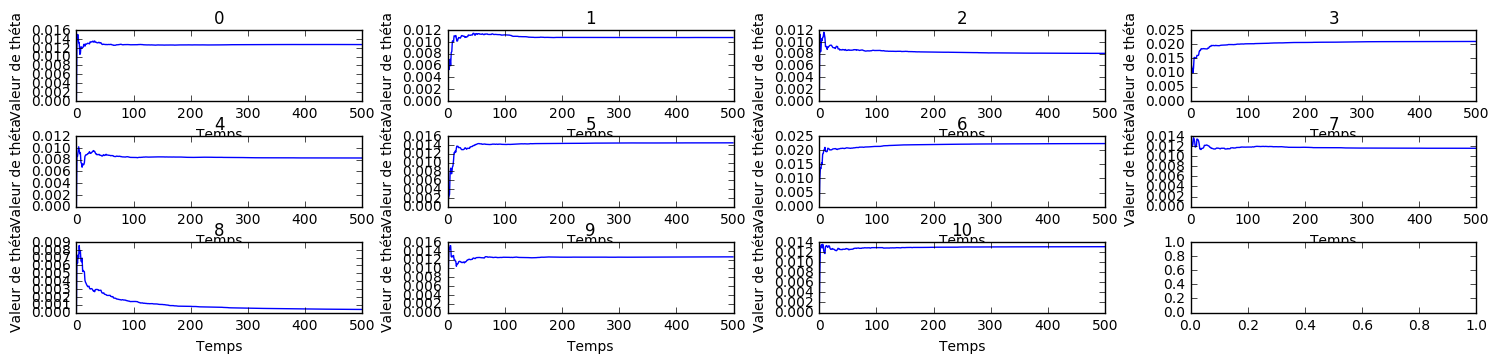

In [98]:
#from matplotlib.pyplot import cm 
figure = pyplot.figure(figsize = (35, 15))
figure.subplots_adjust(left = 0.3, bottom = 0.3, right = 0.7, top = 0.7, 
                       wspace = .3, hspace = .5)

#color = iter(cm.rainbow(np.linspace(0,1,5)))
for i in range(n_features):
    pyplot.subplot(np.ceil(n_features/2), 4, i + 2)
    axes = figure.add_subplot(np.ceil(n_features/2), 4, i + 1)
    axes.set_xlabel('Temps')
    axes.set_ylabel('Valeur de théta')
    axes.set_title(i)
    plt.plot(res["thetamoyen"][:, i]) #, color = next(color)

#### Etudes des coefficients de l'algorithme

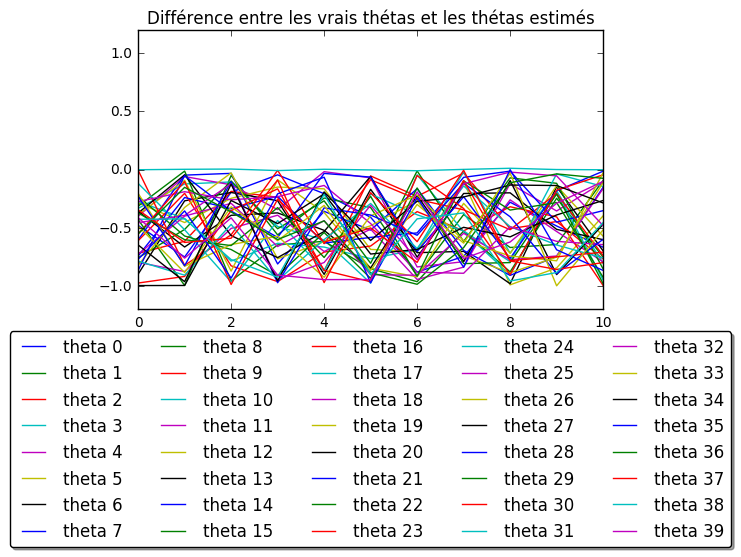

In [99]:
y = res['theta'] - real_theta
labels = ["theta " + str(i) for i in range(n_arms)]
for y_arr, label in zip(y, labels):
    plt.plot(y_arr, label=label)
    
axes = plt.gca()    
ylim = np.max(np.abs([np.max(y),np.min(y)])) # J'ai calculé ça pour que le plot soit plus visible.
axes.set_ylim([-1.2 * ylim, 1.2 * ylim])

box = axes.get_position()
axes.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])

axes.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title('Différence entre les vrais thétas et les thétas estimés')
plt.show()

#### Répartition des différentes stratégies

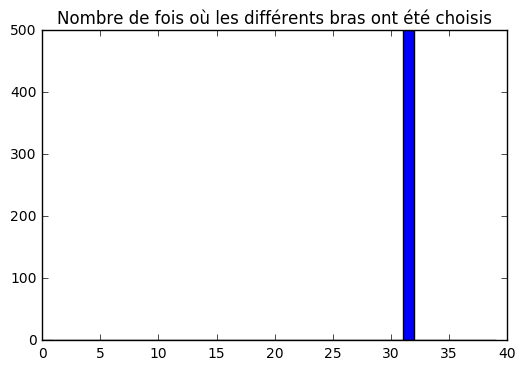

In [100]:
plt.hist(res['best_arm'], bins = np.arange(n_arms))
plt.title("Nombre de fois où les différents bras ont été choisis")

#### Calcul du regret, qui est la différence entre le bras choisi par l'algorithme et la meilleur stratégie possible
(ici on connait la meilleur stratégie car on connait les vrais theta)

In [86]:
#Calcul de la meilleur stratégie
tmp = np.repeat(0.0, T * n_arms).reshape(T, n_arms)
for t in range(T):
    for i in range(n_arms):
        tmp[t, i] = mult(X[i][t, :], real_theta[i, :])
        
real_best_a = np.argmax(tmp, axis = 1)
del(tmp)

best_r = np.repeat(0.0, T)
for t in range(T):
    best_r[t] = mult(X[real_best_a[t]][t, :], real_theta[real_best_a[t], :])

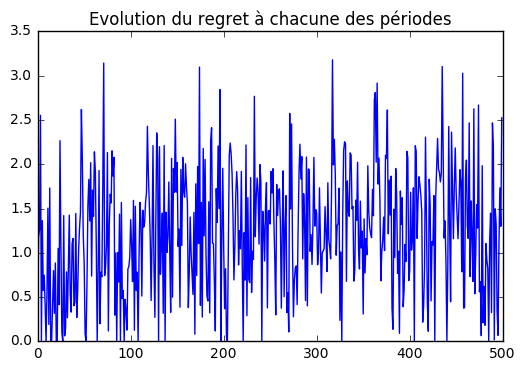

In [87]:
plt.plot(best_r-res["reward"])
plt.title("Evolution du regret à chacune des périodes")

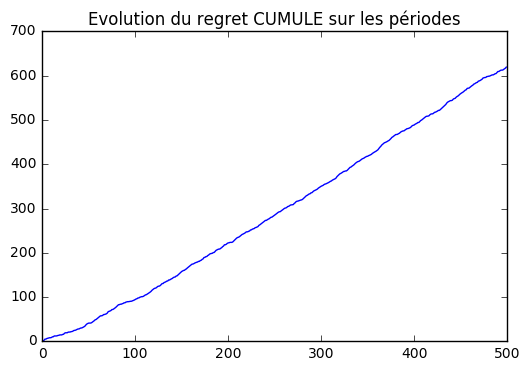

In [88]:
plt.title("Evolution du regret CUMULE sur les périodes")
plt.plot(np.cumsum(best_r - res["reward"]))

On voit que la trajectoire du regret cumulé devient flat au fur et à mesure des itérations, i.e on est bien en train d'apprendre la meilleur stratégie

#### Nombre de fois où l'on a choisi la meilleur stratégie

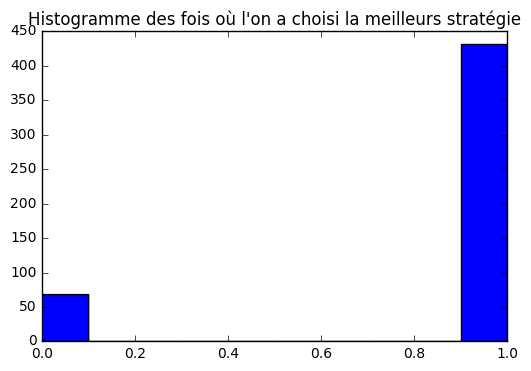

In [70]:
plt.hist(res['best_arm'] == real_best_a)
plt.title("Histogramme des fois où l'on a choisi la meilleurs stratégie")

La barre à l'emplacement zéro = le nombre de fois où l'on s'est trompé, la barre à l'emplacement 1 = le nombre de fois où l'on a eu bon.